In [104]:
# Importing libraries

import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelBinarizer, StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

After Importing required libraries we Import Datasets to train our model

In [105]:
!kaggle competitions download -c playground-series-s4e7

playground-series-s4e7.zip: Skipping, found more recently modified local copy (use --force to force download)


In [106]:
import zipfile

with zipfile.ZipFile('playground-series-s4e7.zip', 'r') as zip_ref:
    zip_ref.extractall('playground_series_s4e7_data')

After Importing the dataset Lets have a first look at our data and its parameters for both test set and training set.

In [107]:


df_test = pd.read_csv('playground_series_s4e7_data/test.csv')
df_test.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271
3,11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115
4,11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148
5,11504803,Male,22,1,30.0,1,< 1 Year,No,25715.0,152.0,245
6,11504804,Female,23,1,20.0,0,< 1 Year,Yes,2630.0,152.0,11
7,11504805,Female,21,1,37.0,1,< 1 Year,Yes,2630.0,160.0,171
8,11504806,Male,72,1,43.0,1,1-2 Year,No,38495.0,124.0,97
9,11504807,Male,33,1,28.0,1,< 1 Year,No,46937.0,152.0,72


In [108]:
df_train = pd.read_csv('playground_series_s4e7_data/train.csv')
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


As we can see here Id is just a parameter that was assigned to keep track of the data tehrefore we need not to add id as a parameter while training our model. We ought to predict the responce parameter for our training data.
This is basically a binary classification problem as we predict either 0 or 1. First we create a backup of our current dataset for robustness. Now we check the integrity of data looking at the data type and description.

In [109]:
df_train_backup = df_train.copy()

In [110]:
df_train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07
mean,5.752398e+06,3.838356e+01,9.980220e-01,2.641869e+01,4.629966e-01,3.046137e+04,1.124254e+02,1.638977e+02,1.229973e-01
std,3.321149e+06,1.499346e+01,4.443120e-02,1.299159e+01,4.986289e-01,1.645475e+04,5.403571e+01,7.997953e+01,3.284341e-01
min,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+00,1.000000e+01,0.000000e+00
25%,2.876199e+06,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,2.527700e+04,2.900000e+01,9.900000e+01,0.000000e+00
50%,5.752398e+06,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,3.182400e+04,1.510000e+02,1.660000e+02,0.000000e+00
75%,8.628598e+06,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,3.945100e+04,1.520000e+02,2.320000e+02,0.000000e+00
max,1.150480e+07,8.500000e+01,1.000000e+00,5.200000e+01,1.000000e+00,5.401650e+05,1.630000e+02,2.990000e+02,1.000000e+00


In [111]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


As we can see form description we have 3 categorical values and 9 numerical values. Now we handle the missing values and duplicate values

In [112]:
df_train.duplicated().sum()
df_train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Fortunately, In our dataset we dont have any duplicate values nor any null values. Now we change the categorical values such as gender and vehicle damage to numerical values using label binarizer because those values would either be yes/no or male or female. 

In [113]:
categorical_features = ['Gender']
categorical_features2 = ['Vehicle_Age']
categorical_features3 = ['Vehicle_Damage']

In [114]:
binarizer = LabelBinarizer()
for col in categorical_features:
    df_train[col] = binarizer.fit_transform(df_train[col])

In [115]:
encoder = LabelEncoder()
for col in categorical_features2:
    df_train[col] = encoder.fit_transform(df_train[col])

In [116]:
binarizer = LabelBinarizer()
for col in categorical_features3:
    df_train[col] = binarizer.fit_transform(df_train[col])

In [117]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                int32  
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           int32  
 7   Vehicle_Damage        int32  
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int32(3), int64(6)
memory usage: 921.6 MB


Now that we have turned all the categorical data into respective numerical data we can start plotting the correlation matrix

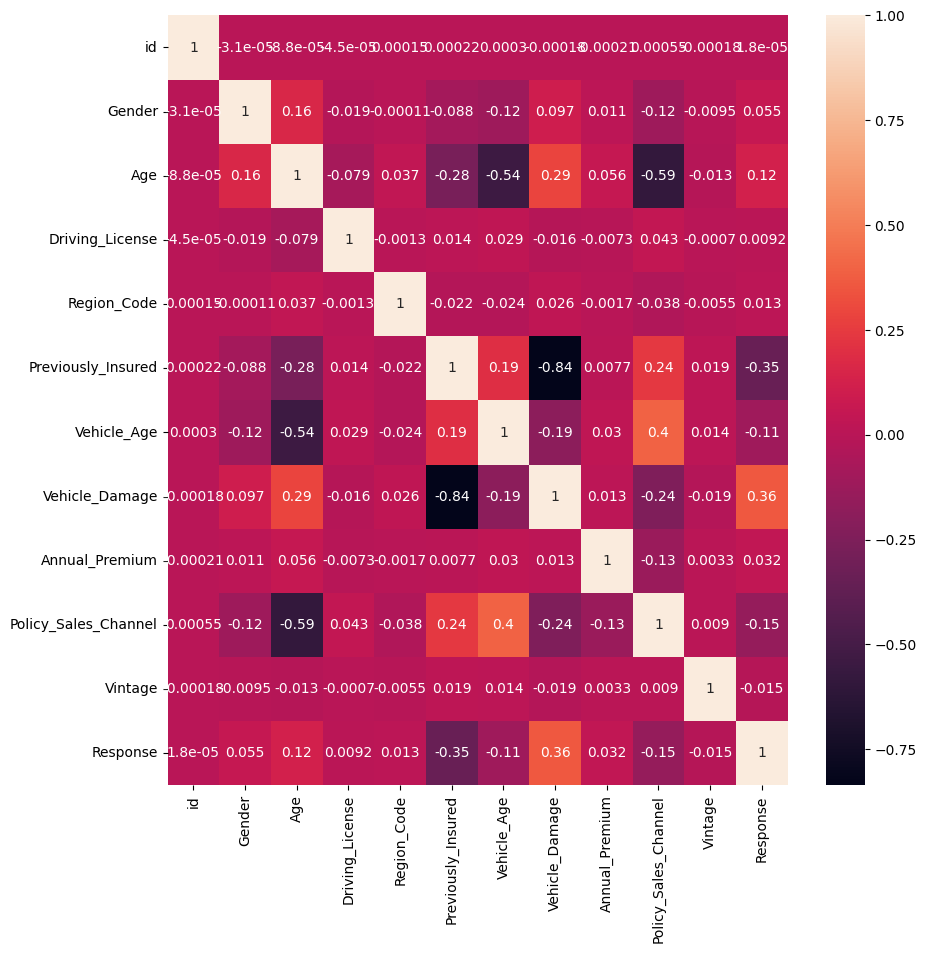

In [118]:
corr_matrix = df_train.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True)
plt.show()

We can see here that response has the strongest correlation between previously insured and vehicle damage. lets scale the data now and start building models.

In [119]:
df_prep = df_train.drop('Response', axis=1)
df_prep = df_train.drop('id', axis=1)
target = df_train['Response']

In [120]:
numeric_columns = df_prep.select_dtypes(include=['float64', 'int32', 'int64']).columns
scaler = StandardScaler()
df_prep[numeric_columns] = scaler.fit_transform(df_prep[numeric_columns])

In [121]:
X_train, X_test, y_train, y_test = train_test_split(df_prep, target, test_size=0.2, random_state=42)

In [122]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [123]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [124]:
X_train_numpy = X_train.values
y_train_numpy = y_train.values

In [103]:
X_train_tensors = torch.tensor(X_train_numpy, dtype=torch.float32)
y_train_tensors = torch.tensor(y_train_numpy, dtype=torch.float32)

TypeError: must be real number, not builtin_function_or_method

In [94]:
input_size = X_train.shape[1]
hidden_size = 128
num_classes = len(pd.unique(y_train))  # Example: number of classes for classification
model = SimpleNN(input_size, hidden_size, num_classes)

In [95]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

In [96]:
num_epochs = 5
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train) 

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float